In [1]:
## calculate RMSE between raytraced result from Sionna and real-life measurements

import argparse
import logging
import os
import itertools

import matplotlib.ticker as mtick
import math

from scipy.constants import speed_of_light
from CBRSUtils import CBRSUtils as cu
# some_file.py
import sys
try:
    from geopy.distance import distance as geopy_dist 
except ModuleNotFoundError:
    !pip install geopy
    from geopy.distance import distance as geopy_dist 
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/home/yl826/3DPathLoss/nc_raytracing/Pytorch-UNet-master')
    
    
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from unet.unet_model_rt import UNet
from utils.utils import plot_img_and_mask

import random

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split

from scipy import ndimage, datasets

dir_checkpoint = Path('./checkpoints_PN/')

building_height_map_dir = os.path.abspath('/dev/shm/res_plane/Bl_building_npy')
terrain_height_map_dir = os.path.abspath('/dev/shm/res_plane/Bl_terrain_npy')
ground_truth_signal_strength_map_dir = os.path.abspath('/dev/shm/coverage_maps_data_aug_Jul18/')
sparse_ss_dir = Path('/home/yl826/3DPathLoss/nc_raytracing/jul18_sparse')

b_map_path_dict = {6: "/home/yl826/3DPathLoss/nc_raytracing/POC/res_plane_duke_PCI6_7/Bl_building_npy/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              7: "/home/yl826/3DPathLoss/nc_raytracing/POC/res_plane_duke_PCI6_7/Bl_building_npy/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              3: "/home/yl826/3DPathLoss/nc_raytracing/POC/res_plane_duke_PCI6_7/Bl_building_npy/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              4: "/home/yl826/3DPathLoss/nc_raytracing/POC/res_plane_duke_PCI6_7/Bl_building_npy/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              20: "/home/yl826/3DPathLoss/nc_raytracing/POC/0_78d03890-be26-47f8-8b81-8485f0d19a83.npy",
              40: "/home/yl826/3DPathLoss/nc_raytracing/POC/0_78d03890-be26-47f8-8b81-8485f0d19a83.npy"}
name_dict = {6: "0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              7: "0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              3: "0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              4: "0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
              20: "0_78d03890-be26-47f8-8b81-8485f0d19a83.npy",
              40: "0_78d03890-be26-47f8-8b81-8485f0d19a83.npy"}

# lat lon pairs, antenna location
lat_lon_center_dict = {6: (35.999186254897836, -78.9397858960648),
                        7: (35.999186254897836, -78.9397858960648),
                        3: (35.999186254897836, -78.9397858960648),
                        4: (35.999186254897836, -78.9397858960648),
                        20: (36.00307128210248, -78.93706070613855),
                        40: (36.00307128210248, -78.93706070613855)}

PCI6_7_3_4_top_left = (36.001483241320656, -78.94273733701348)
lat_lon_top_left_dict = {6: PCI6_7_3_4_top_left,
                         7: PCI6_7_3_4_top_left,
                         3: PCI6_7_3_4_top_left,
                         4: PCI6_7_3_4_top_left,
                         20: (36.005429554748495, -78.93998431793196), 
                         40: (36.005429554748495, -78.93998431793196)}  # lat, lon pairs for top left corner

which_PCI = 20  # these values are possible: 20, 40, 6, 7, 3, 4
print(lat_lon_top_left_dict)

{6: (36.001483241320656, -78.94273733701348), 7: (36.001483241320656, -78.94273733701348), 3: (36.001483241320656, -78.94273733701348), 4: (36.001483241320656, -78.94273733701348), 20: (36.005429554748495, -78.93998431793196), 40: (36.005429554748495, -78.93998431793196)}


In [2]:
from decimal import Decimal
import json
import psycopg2



def rows_to_dict(rowsss, cccursor):
    columns = [desc[0] for desc in cccursor.description]
    result = []
    for rrr in rowsss:
        result.append(dict(zip(columns, rrr)))
    return result



def combine_dicts_to_dict_of_lists(dict_list):
    result = {}
    for dictionary in dict_list:
        for key, value in dictionary.items():
            if key not in result:
                result[key] = []
            result[key].append(value)
    for key in result.keys():
        if isinstance(result[key][0], Decimal):
            for iii, item in enumerate(result[key]):
                result[key][iii] = float(item)
    return result


def get_data_dict():
    connection = psycopg2.connect(database=db_name, user=db_user,
                                  password=db_password, host=db_host, port=db_port)
    cursor = connection.cursor()

    cursor.execute(f"SELECT latitude as latitude, longitude as longitude, "
                   "rsrp as rsrp, azimuth as azimuth FROM \"SigCapDetails\" "
                   # "WHERE (\"mPci\"=40 or \"mPci\"=40) and (\"operatorID\" "
                   "WHERE \"mPci\"=" + str(which_PCI) + " and (\"operatorID\" "
                   "like \'runxi%\' or \"operatorID\" like \'Taro%\')")
    print(which_PCI)
    rows = cursor.fetchall()

    df_ret = combine_dicts_to_dict_of_lists(rows_to_dict(rows, cursor))
    cursor.close()
    connection.close()
    return df_ret


with open("SQLpwd.json", 'r') as file:
    credential = json.load(file)
db_host = credential['db_host']
db_port = credential['db_port']
db_name = credential['db_name']
db_user = credential['db_user']
db_password = credential['db_password']

df_SigCapDetails = get_data_dict()
print(df_SigCapDetails['azimuth'][0:5])
print(df_SigCapDetails['latitude'][0:5])
print(df_SigCapDetails['longitude'][0:5])
print(len(df_SigCapDetails["azimuth"]))
print((df_SigCapDetails['rsrp'][::100]))

# print(df_SigCapDetails['rsrp'])

20
[63.39279568701839, 66.84852306739718, 68.23022935535573, 68.33971045756186, 73.68140333194292]
[36.00307172, 36.00296746, 36.00298388, 36.00297698, 36.00313857]
[-78.93744816, -78.93724173, -78.93729169, -78.93726835, -78.93759875]
4503
[-116, -124, -96, -103, -99, -125, -118, -74, -79, -111, -125, -94, -130, -89, -84, -98, -123, -89, -105, -115, -111, -130, -93, -78, -104, -113, -132, -81, -110, -85, -113, -82, -96, -118, -110, -103, -117, -102, -127, -106, -96, -115, -114, -121, -103, -96]


In [3]:
# 3.Load data
name = name_dict[which_PCI]

name_splited = name.split("_")
file_name_id_part = name_splited[0]
tx_height = 24
tx_x = 256
tx_y = 256
tx_position = [tx_x // 4, tx_y // 4]
distance = np.arange(0, 1450,1)
path_loss_res =  cu.pathloss_38901(distance,3.64, h_bs=int(tx_height), h_ut=2)


building_height_ori = np.load(b_map_path_dict[which_PCI])
building_height_ori = building_height_ori[0:512, 0:512]
building_height_arr = building_height_ori[::4, ::4]



measurement = np.empty([len(df_SigCapDetails["latitude"]), 3])
measurement[:, 0] = df_SigCapDetails["latitude"]
measurement[:, 1] = df_SigCapDetails["longitude"]
measurement[:, 2] = df_SigCapDetails["rsrp"]

for idx, point in enumerate(measurement):
    row, col = cu.gps2local(measurement[idx,0], measurement[idx,1], 
                            top_left_latitude=lat_lon_top_left_dict[which_PCI][0],
                            top_left_longitude=lat_lon_top_left_dict[which_PCI][1])
    measurement[idx, 0] = row
    measurement[idx, 1] = col

ground_truth_list, sparse_ss_arr = np.split(np.random.default_rng(seed=42).permutation(measurement), [len(measurement)-200])
ground_truth_list = measurement

sparse_ss_arr[:,0] = sparse_ss_arr[:,0]/4.0
sparse_ss_arr[:,1] = sparse_ss_arr[:,1]/4.0

increment_permutations = np.array(list(itertools.permutations([-1, 0, 1]))).reshape(-1, 1)

def col_row_for_no_building(row_, col_, bh_arr=building_height_arr, 
                            increment=increment_permutations):
    """
    :param row_: index that has height != 0
    :param col_: index that has height != 0
    :param bh_arr: building height array
    :param increment: tuples for incrementing row,col
    """
    for iii in range(3):
        for jjj in range(3):
            try: 
                height_ = bh_arr[row_+increment[2*iii][jjj], col_+increment[2*iii+1][jjj]]
            except IndexError:
                continue
            if height_ == 0:
                return row_+increment[2*iii][jjj], col_+increment[2*iii+1][jjj]
    # cannot find no building area in 3x3 region
    # print('did not find patch with no building')
    return None, None

print("# of poitn for point-net: ",len(sparse_ss_arr))
print("# of poitn for ground_truth: ",len(ground_truth_list))
#print(sparse_ss_arr)
ground_truth_tmp =  np.empty((128, 128), dtype=object)
count_num_no_building = 0
for point in ground_truth_list:
    row = int(point[0]/4)
    col = int(point[1]/4)
    if row >=128 or col >= 128 or row < 0 or col < 0:
        #print("too large")
        continue
    if building_height_arr[row,col] != 0:
        #print("Building!")
        row, col = col_row_for_no_building(row, col)  # attempts to update row, col 
        if row is None or col is None:  # didn't find good row, col
            count_num_no_building += 1
            continue
        # if building_height_arr[row,col+1] == 0:
        #     col = col + 1
        # else:
        #     #print("Building and no able to move right!")
        #     continue
    #ground_truth_arr_num[row][col] +=1
    
    if ground_truth_tmp[row, col] is None:
        ground_truth_tmp[row, col] = np.array(point[2])
    else:
        ground_truth_tmp[row][col] = np.append(ground_truth_tmp[row][col], point[2])
print("number of points where there's a building", count_num_no_building)
ground_truth_arr = np.empty((128, 128))
for row in range(128):
    for col in range(128):
        if ground_truth_tmp[row, col] is None:
            ground_truth_arr[row][col] = -160
            
        else:
            ground_truth_arr[row][col] = ground_truth_tmp[row,col].mean()
            ground_truth_arr[row][col] = np.median(ground_truth_tmp[row,col])
            ground_truth_arr[row][col] = 10 * np.log10( ( 10 ** ( ground_truth_tmp[row,col]/ 10)  ).mean() )

 # Construct the TX position channel
tx_position_channel = np.full((128, 128), 0, dtype=int)
tx_position_channel[tx_position[1]][tx_position[0]] = tx_height


# def get_pathloss_heat_map(model_name, distance, frequency, h_bs, h_ut):
#     model_dict = {
#         "itm": cu.pathloss_38901,
#         "friis": cu.pathloss_friis_free_space_model,
#         "ericsson": cu.pathloss_ericsson_model,
#     }

    # Construct the Path Loss Model (3GPP TR 308.91 nLos UMa)
path_loss_heat_map = np.full((128, 128), 0, dtype=float)



for row in range(path_loss_heat_map.shape[0]):
    for col in range(path_loss_heat_map.shape[1]):
        # Compute the distance between pixel and tx
        dist = math.sqrt((tx_position[1]*4 - row*4)**2 + (tx_position[0]*4 - col*4)**2)
        path_loss_heat_map[row][col] =  -1 * path_loss_res[int(dist)]





# Since right now GT.size is 100*100 and other two size is 1000 * 1000, just check the input.
# assert building_height_arr.shape == terrain_height_aimport loggin
combined_input = np.zeros((3, 128, 128), dtype=float)

# Combine all the channels together
combined_input[0,:, :] = building_height_arr
ss_map = np.full((128, 128), -160)

res = []
ss_map = np.full((128, 128), -160)
count = 0
while count < 200:
    xx = random.randint(0, 127)
    yy = random.randint(0, 127)
    if ground_truth_arr[xx][yy] != -160 and ss_map[xx][yy] == -160:
        count+=1
        ss_map[xx][yy] = ground_truth_arr[xx][yy]

combined_input[1,:, :] = ss_map
plt.imshow(ss_map)
plt.colorbar()
plt.close()
combined_input[2,:, :] = np.load("/home/yl826/3DPathLoss/nc_raytracing/POC/DukePred34.npy") 

batch = {
            'combined_input': torch.as_tensor(combined_input.copy()).float().contiguous(),
            'ground_truth': torch.as_tensor(ground_truth_arr.copy()).long().contiguous(),
            'file_name': name,
            'sparse_ss': torch.as_tensor(sparse_ss_arr.copy()).float().contiguous()
        }

# of poitn for point-net:  200
# of poitn for ground_truth:  4503
number of points where there's a building 63


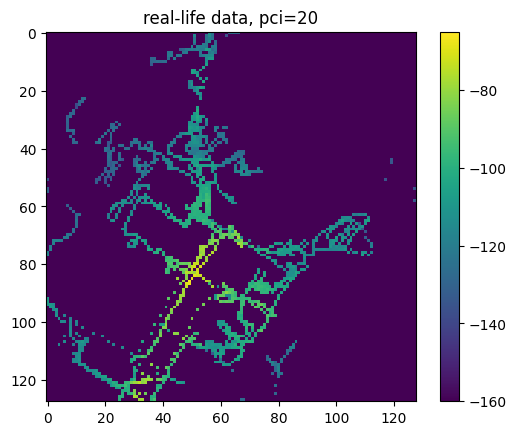

In [4]:
plt.imshow(ground_truth_arr, interpolation='none')
plt.title('real-life data, pci=' + str(which_PCI))
plt.colorbar()

/tmp/ipykernel_686249/4009793609.py:3: RuntimeWarning: divide by zero encountered in log10
  sionna_np = 10*np.log10(np.load(img_path))


23.35492553793358


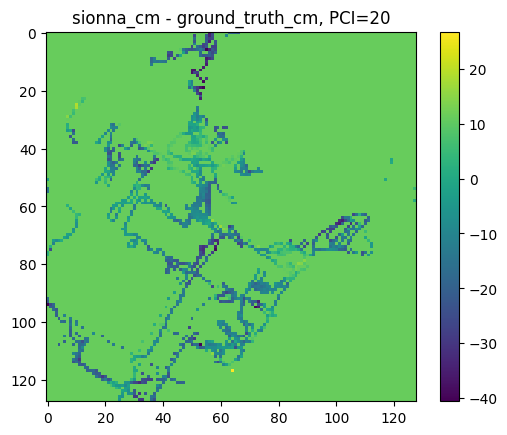

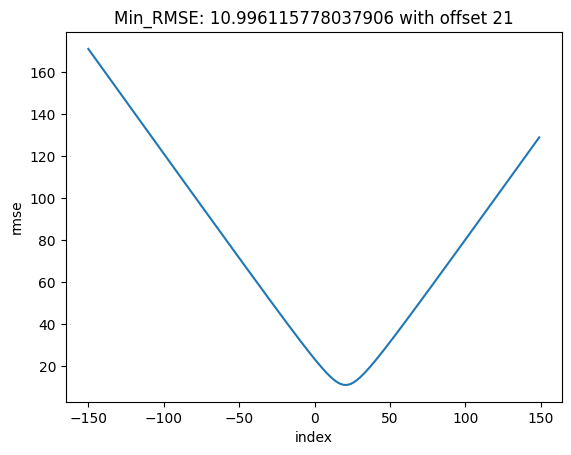

In [5]:
img_path='/home/yl826/3DPathLoss/nc_raytracing/cm_plane_duke_pci20_7e6_my_antennaTx/0_78d03890-be26-47f8-8b81-8485f0d19a83_-244_244_22_250_20.npy'

sionna_np = 10*np.log10(np.load(img_path))
sionna_np = np.nan_to_num(sionna_np, copy=True, nan=-160, posinf=-160, neginf=-160)

def compute_mse_ground_truth_sionna(ground_truth_cm, sionna_cm):
    idx_160 = (np.array(ground_truth_cm) != -160).astype(int)
    # mask. val != -160 -> mask at val will be set to True
    for row in range(128):
        for col in range(128):
            if row > 105 and col > 75:
                idx_160[row, col] = 0
            if row > 120 and col > 60:
                idx_160[row, col] = 0
    ground_truth_cm = ground_truth_cm.copy()
    sionna_cm = sionna_cm.copy()
    
    ground_truth_cm *= idx_160
    sionna_cm *= idx_160  # places where ground_truth_cm has no valid data is set to zero
    
    sionna_cm[sionna_cm == 0] = -160  # then invalid data is set to -160
    sionna_cm[sionna_cm < -160] = -160
    ground_truth_cm[ground_truth_cm == 0] = -160 # at this point sionna_cm's pattern
    # looks like ground_truth_cm when plotted
    

    
    ground_truth_cm_flat = ground_truth_cm.flatten()
    sionna_cm_flat = sionna_cm.flatten()
    
   
    offset = range(-150,150)
    # collect lists where valid data exists in ground_truth_data
    sionna_cm_data = np.array([sionna_cm_flat[iii] for iii, val in enumerate(ground_truth_cm_flat) if val != -160])
    ground_truth_data = np.array([i for i in ground_truth_cm.flatten() if i != -160])
    
    orig_rmse = mean_squared_error(sionna_cm_data, ground_truth_data, squared=False)
    with_offset_rmse = []
    for i in offset:
        with_offset_rmse.append(mean_squared_error(sionna_cm_data+i, ground_truth_data, squared=False))
    fig, ax = plt.subplots(1, 1)
    ax.set_title('sionna_cm - ground_truth_cm, PCI='+ str(which_PCI))
    img = ax.imshow(sionna_cm - ground_truth_cm +np.min(with_offset_rmse) , interpolation='none')
    #img = ax.imshow(sionna_cm, interpolation='none')
    #ax.set_title('sionna cm, PCI='+str(which_PCI))
    fig.colorbar(img)
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(offset, with_offset_rmse)
    ax.set_title('Min_RMSE: %s with offset %s'%(np.min(with_offset_rmse) , offset[np.argmin(with_offset_rmse)]))
    ax.set_xlabel('index')
    ax.set_ylabel('rmse')
    return orig_rmse

# print(mean_squared_error(sionna_np, ground_truth_arr, squared=False))
print(compute_mse_ground_truth_sionna(ground_truth_arr, sionna_np))